In [55]:
import pandas as pd
pd.set_option('display.max_rows', 11000)
import requests
from bs4 import BeautifulSoup

# language dictionary
r = requests.get('https://arch-bip.ms.gov.pl/pl/rejestry-i-ewidencje/tlumacze-przysiegli/lista-tlumaczy-przysieglych/search.html')
soup = BeautifulSoup(r.text, 'html.parser')

for i in soup.find_all('select', attrs = {'name':'Language'}):
    for option in i.find_all('option'):
        lang_dict[option['value']] = option.text
lang_dict.pop('') # empty record removed
lang_dict.pop('64') # czarnogórski removed

results = []
for language in lang_dict:
    
    # number of pages
    r = requests.get(f'https://arch-bip.ms.gov.pl/pl/rejestry-i-ewidencje/tlumacze-przysiegli/lista-tlumaczy-przysieglych/search.html?Language={language}')
    soup = BeautifulSoup(r.text, 'html.parser')
    page_list = []
    tags = soup.find_all('a', href = True)
    
    try:
        for tag in tags:
            page_list.append(tag.get_text())
        extracted_list = [s for s in page_list if s.isdigit()]
        extracted_list = [int(s) for s in extracted_list]
        extracted_list.sort()
        max_page = extracted_list[-1]
        page_list = list(range(1, max_page + 1))
        pages = [',' + str(s) for s in page_list]
    except:
        pages = ['']

    # collect data
    for page in pages:
        r = requests.get(f'https://arch-bip.ms.gov.pl/pl/rejestry-i-ewidencje/tlumacze-przysiegli/lista-tlumaczy-przysieglych/search{page}.html?Language={language}')
        soup = BeautifulSoup(r.text, 'html.parser')
        html_table = soup.find_all('table')[0]
        temp_table = []
        for row in html_table.find_all('tr'):
            my_row_td = [element.get_text(strip = True) for element in row.find_all('td')]
            if  my_row_td:
                temp_table.append(my_row_td)
            my_row_th = [element.get_text(strip = True) for element in row.find_all('th')]
            if  my_row_th:
                temp_table.append(my_row_th)
        translators = pd.DataFrame(temp_table[1:], columns = temp_table[0])
        translators['Język'] = lang_dict[language] # adding 'Language' column
        results.append(translators)
        df = pd.concat(results, ignore_index = True, sort = False)

# DataFrame shaping
df = df[['Imię', 'Język', 'Województwo']]
df['Imię'] = df['Imię'].str.replace('\n\t\t\t', '', case = False)
df.sort_values(['Język', 'Imię'], inplace=True)
df = df.reset_index(drop=True)
file_name = r'C:\Users\admin\Documents\Nauka\Python projects\06 Translators\translators.csv'
df.to_csv(file_name, sep = '\t', encoding = 'utf-8', index = False)

print(df.shape)
df.head()

(10841, 3)


,Imię,Język,Województwo
0,Bekteshi Ewa,albański,kujawsko-pomorskie
1,Bekteshi Orges,albański,kujawsko-pomorskie
2,Dargiel Karolinadr nauk hum.,albański,małopolskie
3,Jarecki Krzysztof,amharski,mazowieckie
4,Abriszewska-Moreau Dariadr nauk hum.,angielski,kujawsko-pomorskie


NameError: name 'figsize' is not defined

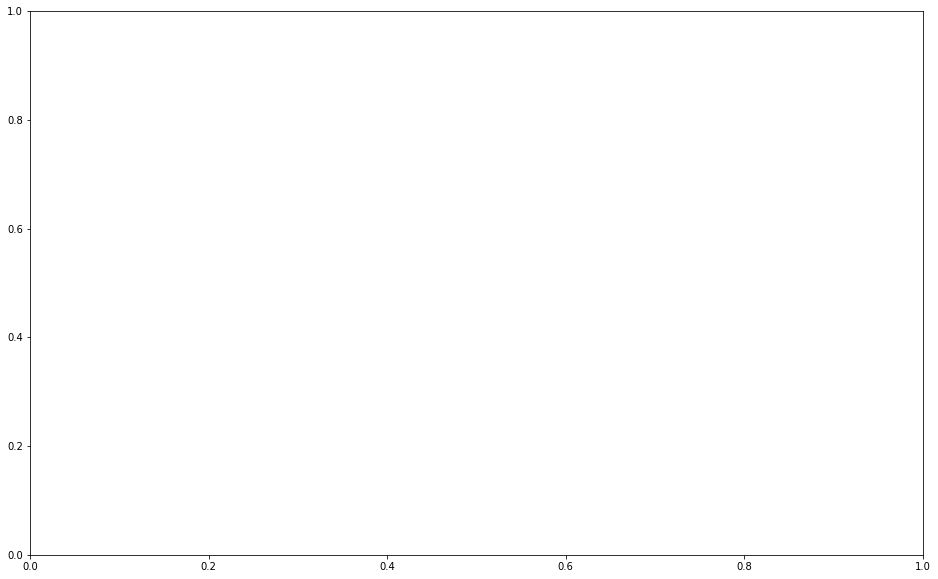

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

# load shapefile
map_shp = r'C:\Users\admin\Documents\Nauka\Python projects\06 Translators\wojewodztwa\województwa.shp'
map_df = gpd.read_file(map_shp, encoding = 'utf-8')
# map_df.plot()

# load translators DataFrame
file_name = r'C:\Users\admin\Documents\Nauka\Python projects\06 Translators\translators_raw.csv'
df = pd.read_csv(file_name, sep = '\t', encoding = 'utf-8')
# df.head()

df_woj = df.groupby('Województwo').count()[['Język']]
df_woj = df_woj.reset_index()

df_merged = map_df.merge(df_woj, left_on = 'jpt_nazwa_', right_on = 'Województwo')
# print(type(df_merged))

# plotting map
colors = 9
cmap = 'Blues'
fig, ax = plt.subplots(1, figsize = (16, 10))
df_merged.plot(column = 'Język', cmap=cmap, figsize=figsize, scheme='equal_interval', k=colors, ax=ax, legend=False, linewidth=0.8, edgecolor='0.8')
ax.axis('off')
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=150, vmax=2100))
# sm._A = []